<a href="https://colab.research.google.com/github/EsserMishelle/short-term-stock-forecast/blob/main/ARIMA_univariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
The objective of this project is to forecast the short-term closing price of NVIDIA (NVDA) stock using classical time-series models and compare their performance using information criteria and forecast accuracy.

In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import seaborn as sns
import os
import time

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load NVDA price and volume and merge them together

In [35]:
# --- Load the price file ---
price_df = pd.read_csv(
    '/content/drive/MyDrive/stocks/stock_price_2021_2026.csv',
    index_col='Date',
    parse_dates=True
)

# Filter out only 'Close' related columns
close_df = price_df.filter(like='_Close').copy()

# Remove caret^ and lowercase column names
close_df.columns = (
    close_df.columns
        .str.replace('^', '', regex=False)   # remove caret ^
        .str.lower()
)

# Flatten multi-index columns
close_df.columns = [
    '_'.join(col).strip() if isinstance(col, tuple) else col
    for col in close_df.columns
]

display(close_df.info())
print()

display(close_df.describe())
print()

display(close_df.head())
print()
display(close_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1278 entries, 2021-01-04 to 2026-02-04
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   amd_close   1278 non-null   float64
 1   tsm_close   1278 non-null   float64
 2   tnx_close   1278 non-null   float64
 3   qqq_close   1278 non-null   float64
 4   vix_close   1278 non-null   float64
 5   nvda_close  1278 non-null   float64
dtypes: float64(6)
memory usage: 69.9 KB


None

,amd_close,tsm_close,tnx_close,qqq_close,vix_close,nvda_close
count,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000
mean,123.029421,137.752928,3.384294,403.124009,19.287801,69.329726
std,42.477132,64.525107,1.146447,101.989702,5.260509,59.103824
min,55.939999,57.205887,0.917000,255.265411,11.860000,11.212903
25%,90.902502,90.165962,2.644500,319.557472,15.625000,19.515131
50%,112.084999,110.398651,3.878500,369.977768,17.995000,42.327456
75%,150.435001,172.072075,4.258000,479.328476,21.889999,121.585546
max,264.329987,342.399994,4.988000,634.951965,52.330002,207.028473


,amd_close,tsm_close,tnx_close,qqq_close,vix_close,nvda_close
Date,,,,,,
2021-01-04,92.300003,102.714409,0.917,300.163116,26.969999,13.076725
2021-01-05,92.769997,103.698318,0.955,302.637726,25.340000,13.367163
2021-01-06,90.330002,106.309875,1.042,298.445435,25.070000,12.579125
2021-01-07,95.160004,111.661697,1.071,305.665466,22.370001,13.306579
2021-01-08,94.580002,109.142113,1.105,309.595673,21.559999,13.239517


,amd_close,tsm_close,tnx_close,qqq_close,vix_close,nvda_close
Date,,,,,,
2026-01-29,252.179993,339.549988,4.227,629.429993,16.879999,192.509995
2026-01-30,236.729996,330.559998,4.241,621.869995,17.440001,191.130005
2026-02-02,246.270004,341.359985,4.275,626.140015,16.340000,185.610001
2026-02-03,242.110001,335.750000,4.274,616.520020,18.000000,180.339996
2026-02-04,200.190002,325.739990,4.275,605.750000,18.639999,174.190002


### The result shows the DataFrame has 2023 entries and 15 columns with no null values.

In [36]:
# # Divide the stocks DataFrame by TICKER and duplicate it.
nvda = close_df[['nvda_close']].copy()
amd = close_df[['amd_close']].copy()
tsm = close_df[['tsm_close']].copy()
qqq = close_df[['qqq_close']].copy()

# All indices are sorted chronologically to preserve temporal order.
nvda = nvda.sort_index()
amd = amd.sort_index()
tsm = tsm.sort_index()
qqq = qqq.sort_index()

## Define the prediction task

This project focuses on classical time-series forecasting methods demonstrated in class, comparing ARIMA, Prophet, and linear trend models using AIC and forecast error metrics.

In [37]:
# Predict whether NVDA’s 5-day return exceeds a minimum meaningful threshold.

# threshold = 0.01 #(1%)

# nvda['future_return_5d'] = nvda['Close'].pct_change(5).shift(-5)
# nvda['target'] = (nvda['future_return_5d'] > threshold).astype(int)
# nvda

# nvda['target'].value_counts(normalize=True)

In [38]:
display(nvda.head())
display(nvda.tail())

,nvda_close
Date,
2021-01-04,13.076725
2021-01-05,13.367163
2021-01-06,12.579125
2021-01-07,13.306579
2021-01-08,13.239517


,nvda_close
Date,
2026-01-29,192.509995
2026-01-30,191.130005
2026-02-02,185.610001
2026-02-03,180.339996
2026-02-04,174.190002


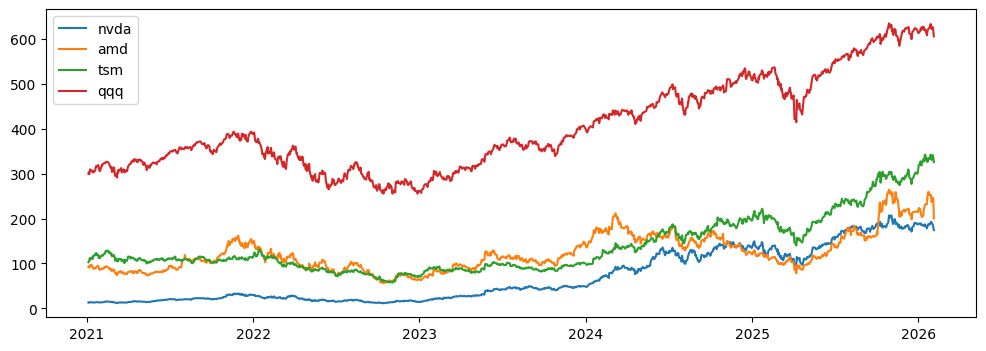

In [39]:
plt.figure(figsize=(12, 4))

plt.plot(nvda.index, nvda['nvda_close'], label='nvda')
plt.plot(amd.index, amd['amd_close'], label='amd')
plt.plot(tsm.index, tsm['tsm_close'], label='tsm')
plt.plot(qqq.index, qqq['qqq_close'], label='qqq')

plt.legend()

plt.show()


The chart indicates that all three stocks (NVDA, AMD, TSM, QQQ) have a non-stationary series. NVDA's trend has minor incline but rose sharply starting from 2024. Even with minor drop in early 2025, the stock price seems to be going upward. These 4 stocks have very similar pattern. AMD fell below NVDA early 2025 but have since recovered and surpassed NVDA.

In [40]:
arima_ts = nvda['nvda_close']
arima_ts.index = pd.to_datetime(arima_ts.index) # Make sure arima_ts has a datetime index
arima_ts = arima_ts.asfreq('B') # Only business work days (M-F)
arima_ts

,nvda_close
Date,
2021-01-04,13.076725
2021-01-05,13.367163
2021-01-06,12.579125
2021-01-07,13.306579
2021-01-08,13.239517
...,...
2026-01-29,192.509995
2026-01-30,191.130005
2026-02-02,185.610001


## ARIMA (Autoregressive Integrated Moving Average)

### The ARIMA (Autoregressive Integrated Moving Average) model is a commonly used approach for forecasting time-series data. It works by combining information from past values of the series, changes between observations, and past forecast errors to model the underlying structure of the data. By incorporating **autoregression (AR), differencing (I), and moving-average terms (MA)**, ARIMA is able to capture trends and short-term patterns in historical data and use them to generate future forecasts.




## Choose Model (in-sample)
### ADF Differencing
#### Because ARIMA models require a stationary time series, the stationarity of the NVDA closing price data is first evaluated using the **Augmented Dickey–Fuller (ADF)** test. The ADF test checks for the presence of a unit root, where a failure to reject the null hypothesis indicates non-stationarity and the need for differencing before model fitting.

The test result shows the p-value (.97) is > .05 and the test statistic is above all critical values, so it fails to reject the null hypothesis. In other words, NVDA closing pric series is non-stationary.

To address this, first differencing is applied, which removes trend effects by modeling changes between consecutive observations rather than absolute price levels.

In [41]:
adfuller(arima_ts.diff().dropna())
print(adfuller(arima_ts.diff().dropna())[1])

1.3077902558195e-07


After differencing, the ADF test strongly rejected the null hypothesis (p < 0.001) and that the transformed series now is stationary.
This proves that the first differencing is required to satisfy the assumptions of ARIMA modeling, corresponding to d = 1 in the ARIMA(p, d, q) specification.

### Autoregressive (AR) Models - obtain d

In [42]:
arima_ts_diff = arima_ts.diff().dropna()
arima_ts_diff

,nvda_close
Date,
2021-01-05,0.290438
2021-01-06,-0.788037
2021-01-07,0.727453
2021-01-08,-0.067061
2021-01-11,0.343784
...,...
2026-01-29,0.989990
2026-01-30,-1.379990
2026-02-02,-5.520004


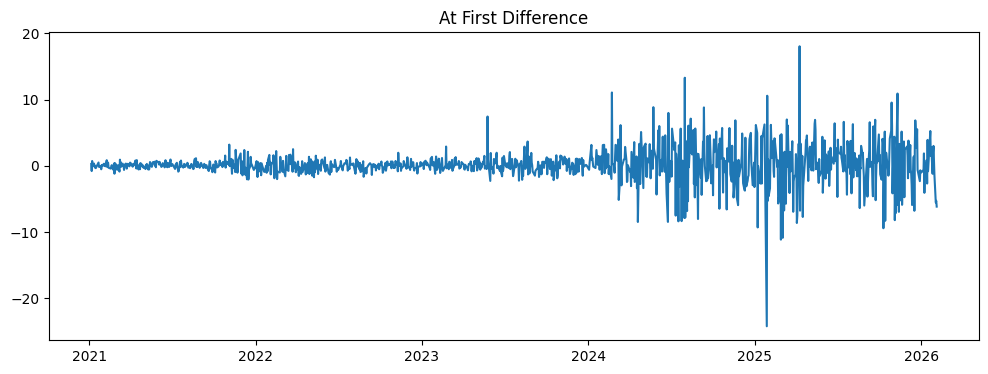

In [43]:
plt.figure(figsize=(12, 4))
plt.plot(arima_ts_diff)
plt.title('At First Difference')
plt.show()

## ACF/PACF - Candidate p, q

Text(0, 0.5, 'Correlation')

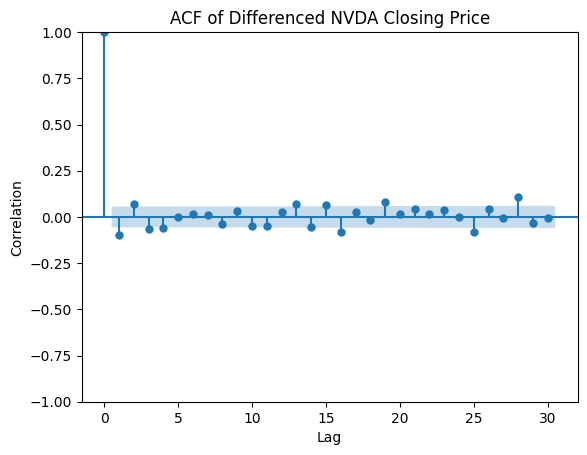

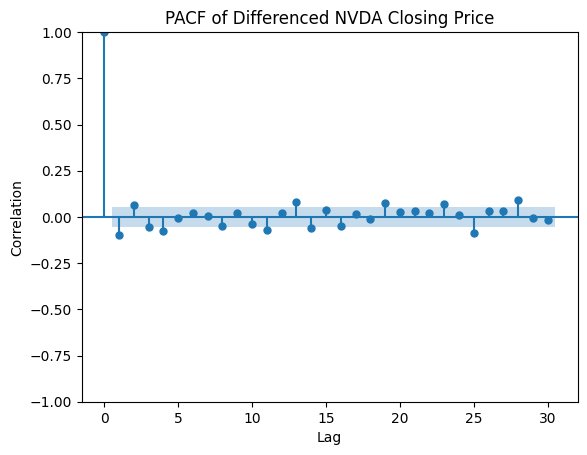

In [44]:
plot_acf(arima_ts_diff, lags=30)
plt.title('ACF of Differenced NVDA Closing Price')
plt.xlabel('Lag')
plt.ylabel('Correlation')

plot_pacf(arima_ts_diff, lags=30)
plt.title('PACF of Differenced NVDA Closing Price')
plt.xlabel('Lag')
plt.ylabel('Correlation')


###* ACF Plot Interpretation:
* Low Autocorrelation: Since all lag correlations are close to zero, this suggests that the series is likely to be white noise or has very short memory. There are no lags showing significant autocorrelation.
* Model Implications: If ACF does not show significant spikes, it indicates that you might consider a lower or possibly no moving average (MA) component.

### Interpretation of the ACF Plot:
Low Autocorrelation: Since all lag correlations are close to zero, this suggests that the series is likely to be white noise or has very short memory. There are no lags showing significant autocorrelation.
*Model Implications: If ACF does not show significant spikes, it indicates that you might consider a lower or possibly no moving average (MA) component.

After first differencing, both the ACF and PACF exhibit minimal autocorrelation, with no strong spikes beyond lag 1. This indicates that the differenced series behaves similarly to white noise, which is typical for financial return data. A parsimonious ARIMA(1,1,1) model is therefore selected to capture any remaining short-term dependence.

## AIC Grid Search - to obtain p, d, q

In [64]:
# from statsmodels.tsa.arima.model import ARIMA

best_aic = np.inf
best_order = None

# convert ts to only use business days
# ts = ts.asfreq('B')  # business days

# for the AR compnent (p)
for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(arima_ts, trend='t', order=(p,1,q)) # Add a trend element
            fit = model.fit()
            if fit.aic < best_aic:
                best_aic = fit.aic
                best_order = (p,1,q)
        except:
            continue

print("Best:", best_order, "AIC:", best_aic)

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best: (4, 1, 4) AIC: 6018.661121322619


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


While ARIMA(4,1,4) achieved the lowest AIC, a simpler ARIMA(1,1,1) model was selected due to its interpretability and stability, given the weak autocorrelation structure of the differenced series.

Best model = ARIMA(4, 1, 4)

## Refit the Model Using Only the Training Data
### Train-Test-Split

In [65]:
arima_train = arima_ts.iloc[:-90]
arima_test = arima_ts.iloc[-90:]

### ARIMA Fit Train Data Only

In [66]:
arima_train_model = ARIMA(arima_train, order =(4,1,4), trend='t')
arima_train_fit= arima_train_model.fit()
arima_train_fit.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             nvda_close   No. Observations:                 1238
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -2726.876
Date:                Fri, 13 Feb 2026   AIC                           5473.751
Time:                        06:12:31   BIC                           5524.956
Sample:                    01-04-2021   HQIC                          5493.011
                         - 10-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1454      0.061      2.398      0.016       0.027       0.264
ar.L1         -0.0817      0.279     -0.293      0.769      -0.628       0.464
ar.L2         -0.2069      0.146     -1.417      0.157      -0.493       0.079
ar.L3          0.4291      0.198      2.170      0.030       0.042       0.817
ar.L4          0.4189      0.128      3.273      0.001       0.168       0.670
ma.L1         -0.0146      0.281     -0.052      0.959      -0.565       0.536
ma.L2          0.3044      0.135      2.251      0.024       0.039       0.569
ma.L3         -0.5193      0.210     -2.475      0.013      -0.931      -0.108
ma.L4         -0.3953      0.145     -2.735      0.006      -0.679      -0.112
sigma2         5.5408      0.090     61.831      0.000       5.365       5.716
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):             13511.35
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):              26.04   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Diagnostic Check (still in-sample)
## Chart fit.resid

In [67]:
resid = arima_train_fit.resid.dropna()
resid

,0
Date,
2021-01-04,12.931362
2021-01-05,0.145083
2021-01-06,-0.917430
2021-01-07,0.475626
2021-01-08,-0.072664
...,...
2025-09-25,1.236436
2025-09-26,0.045412
2025-09-29,3.256734


#### The residual dignostic chart checks training assumptions and validate the residual patterns are just white noise and that (4, 1,4) is not underfitting

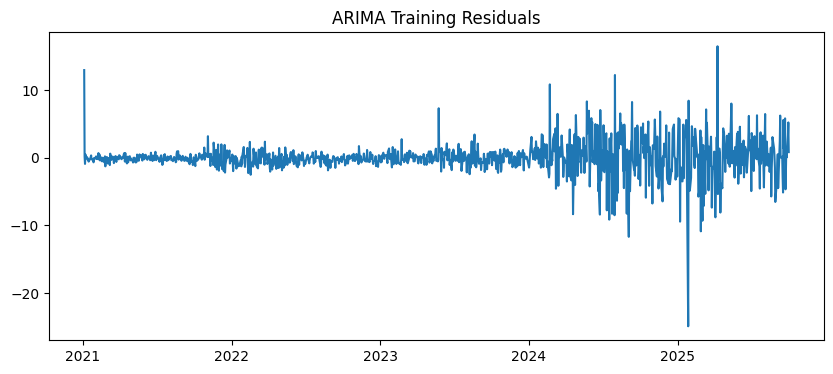

In [49]:
plt.figure(figsize=(10,4))
plt.plot(resid)
plt.title('ARIMA Training Residuals')
plt.show()

## Plot acf and pact of fit.resid

<Figure size 1000x400 with 0 Axes>

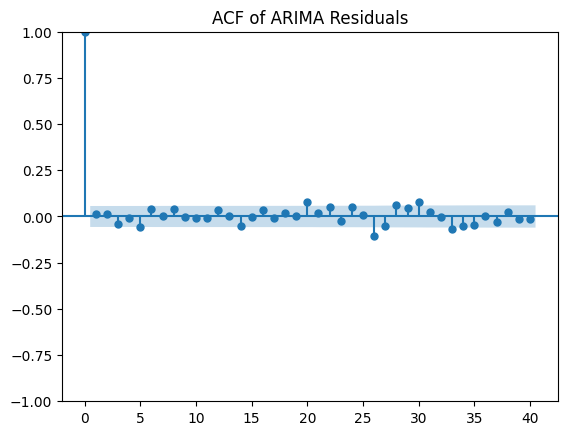

<Figure size 1000x400 with 0 Axes>

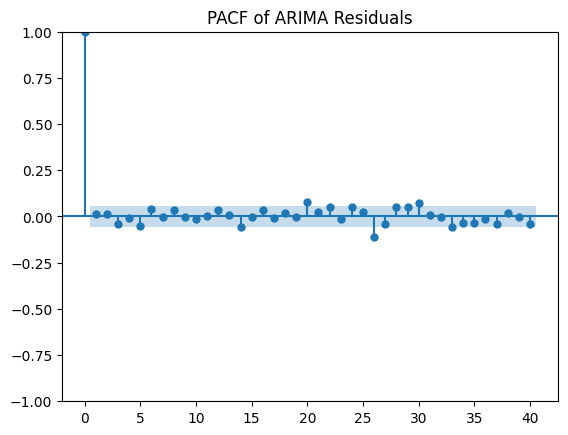

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plot_acf(resid, lags=40)
plt.title('ACF of ARIMA Residuals')
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(resid, lags=40)
plt.title('PACF of ARIMA Residuals')
plt.show()

In [51]:
forecast = arima_train_fit.get_forecast(steps=len(arima_test))
pred = forecast.predicted_mean
pred


,predicted_mean
2025-10-02,187.901204
2025-10-03,187.596972
2025-10-06,187.328496
2025-10-07,187.717449
2025-10-08,187.956050
...,...
2026-01-29,198.979477
2026-01-30,199.124735
2026-02-02,199.270033
2026-02-03,199.415503


In [52]:
print(f'arima_test has: {arima_test.isnull().sum()} NaNs')
print(f'pred has: {pred.isnull().sum()} NaNs')

# arima_test set has NaN because of market holidays.
# pred has no NaNs because ARIMA predicts every step


arima_test_clean = arima_test.dropna()
pred_clean = pred.loc[arima_test_clean.index]


arima_test has: 4 NaNs
pred has: 0 NaNs


### Remove market holidays from ARIMA train dataset

In [53]:
arima_test_clean = arima_test.dropna()
pred_clean = pred.loc[arima_test_clean.index]

In [68]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

def arima_metrics(train, test, fit):
    """
    train: training time series (pd.Series)
    test: test time series (pd.Series)
    fit: fitted ARIMA model on train
    """

    # -------- TRAIN predictions (in-sample) --------
    y_pred_train = fit.fittedvalues

    # align and drop NaNs
    train_eval = pd.concat([train, y_pred_train], axis=1).dropna()
    train_eval.columns = ['actual', 'pred']

    # -------- TEST predictions (out-of-sample) --------
    forecast = fit.get_forecast(steps=len(test))
    y_pred_test = forecast.predicted_mean

    test_eval = pd.concat([test, y_pred_test], axis=1).dropna()
    test_eval.columns = ['actual', 'pred']

    # -------- METRICS --------
    metrics = {
        'MAE_train': mean_absolute_error(train_eval['actual'], train_eval['pred']),
        'MAE_test': mean_absolute_error(test_eval['actual'], test_eval['pred']),

        'RMSE_train': np.sqrt(mean_squared_error(train_eval['actual'], train_eval['pred'])),
        'RMSE_test': np.sqrt(mean_squared_error(test_eval['actual'], test_eval['pred'])),

        'MAPE_train': mean_absolute_percentage_error(train_eval['actual'], train_eval['pred']),
        'MAPE_test': mean_absolute_percentage_error(test_eval['actual'], test_eval['pred']),
    }

    return metrics

In [56]:
arima_results = arima_metrics(
    arima_train,
    arima_test,
    arima_train_fit
)

arima_results

{'MAE_train': 1.409133480953089,
 'MAE_test': 9.568868796324137,
 'RMSE_train': np.float64(2.416209101754613),
 'RMSE_test': np.float64(10.963729234718882),
 'MAPE_train': 0.025765236388288235,
 'MAPE_test': 0.05190990472804922}

In [57]:
rmse_arima = arima_results['RMSE_test']
mae_arima  = arima_results['MAE_test']
mape_arima = arima_results['MAPE_test']

arima_metrics_export = pd.DataFrame({
    'Model': ['ARIMA'],
    'Test_RMSE': [rmse_arima],
    'Test_MAE':  [mae_arima],
    'Test_MAPE': [mape_arima]
})

display(arima_metrics_export)
arima_metrics_export.to_csv('arima_metrics.csv', index=False)


,Model,Test_RMSE,Test_MAE,Test_MAPE
0,ARIMA,10.963729,9.568869,0.05191


## Get ARIMA forecast for the full dataset

In [58]:
arima_full_model = ARIMA(
    arima_ts,
    order=(4,1,4),   # use the order you selected
    trend='t'
)

arima_full_fit = arima_full_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Forecast next 30 business days

In [59]:
arima_forecast_30 = arima_full_fit.get_forecast(steps=30)
pred_30 = arima_forecast_30.predicted_mean
ci_30 = arima_forecast_30.conf_int()


In [99]:
pred_30

,predicted_mean
2026-02-05,174.382675
2026-02-06,174.422074
2026-02-09,175.601618
2026-02-10,175.715806
2026-02-11,175.463123
2026-02-12,175.996666
2026-02-13,176.627483
2026-02-16,176.362316
2026-02-17,176.360333
2026-02-18,177.002643


Plot 2021-2026 + Forecast

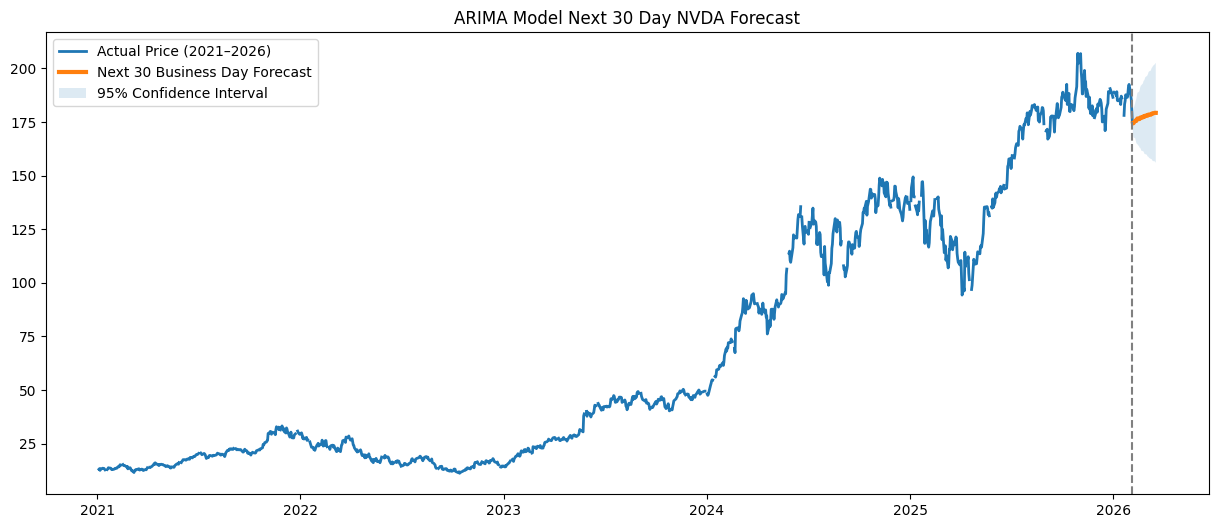

In [101]:
plt.figure(figsize=(15,6))

plt.plot(arima_ts, label='Actual Price (2021–2026)',  linewidth=2)
plt.plot(pred_30, label='Next 30 Business Day Forecast', linewidth=3)
plt.fill_between(
    ci_30.index,
    ci_30.iloc[:,0],
    ci_30.iloc[:,1],
    alpha=0.15,
    label='95% Confidence Interval',
)
plt.axvline(arima_ts.index[-1], linestyle='--', color='gray')
# plt.xlim(arima_ts.index[0], pred_30.index[-1])
plt.legend()
plt.title('ARIMA Model Next 30 Day NVDA Forecast')
plt.show()

Business days only and next trading day are applied to see the next 30 days forecase along with the last 90 days trend.

Plot ZOOMED view (last 90 days + 30 days prediction)

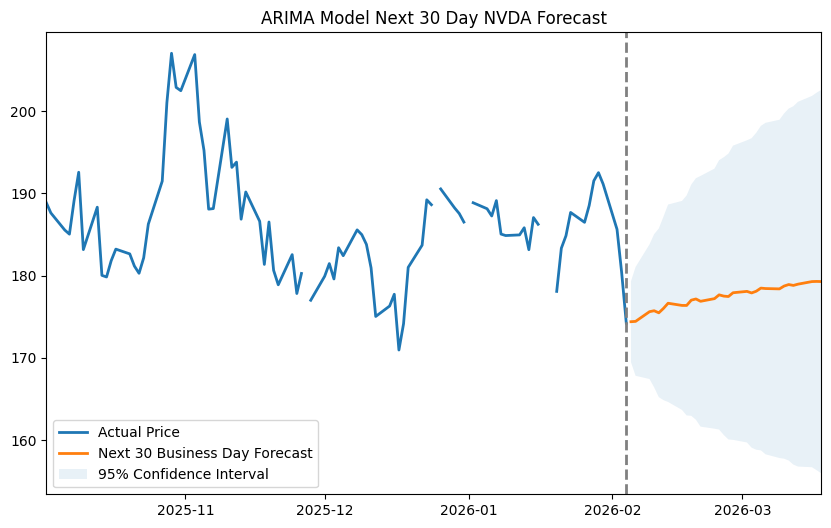

In [88]:
start_zoom = arima_ts.index[-90]
end_zoom = ci_30.index[-1]

plt.figure(figsize=(10,6))

plt.plot(
    arima_ts.loc[start_zoom:],
    label ='Actual Price',
    linewidth=2
)

plt.plot(
    pred_30, label='Next 30 Business Day Forecast',  linewidth=2)

plt.fill_between(
    ci_30.index,
    ci_30.iloc[:,0],
    ci_30.iloc[:,1],
    alpha=.10,
    label='95% Confidence Interval',
)
plt.axvline(arima_ts.index[-1], linestyle='--', color='gray', linewidth=2)

plt.xlim(start_zoom, end_zoom)

plt.legend()
plt.title('ARIMA Model Next 30 Day NVDA Forecast')
plt.show()

## An ARIMA(3,1,3) model with a drift term was also evaluated to account for persistent upward movement in the series. While the drift-adjusted model produces a modest upward forecast, it remains conservative and does not extrapolate recent price spikes. This behavior is consistent with financial theory, where short-term stock price movements are largely unpredictable and best modeled as a random walk with drift.



---

